# Gaussian Processes for Regression

In this tutorial we're going to discuss Gaussian Processes.

No tutorial on Gaussian Processes would be complete without starting with the somewhat opaque sentence:

> A Gaussian Process is a distribution over functions.

## Background 
I'm going to go through some background material, feel free to skip sections if you already feel comfortable with them.

### Regression vs Classification

Broadly speaking, most tasks in data science are either classification, or regression. In this tutorial I'm only going to discuss regression (though GPs are capable of doing classification, they are most naturally suited to regression).

### The Gaussian Distribution 

- Introduce the Gaussian distribution
- some notation (mean, variance) 
- basketballers example 
- multivariate Gaussians
- covariance 

The Gaussian distribution (also commonly referred to as the Normal distribution) is one of the most heavily used distributions in data science and machine learning. This is in large part because they appear so often in the world (TODO: reference central limit theorem, law of large numbers), but also because they offer a great deal of mathematical convenience.

A _univariate_ Gaussian distribution is specified by a mean ($\mu$) and a variance ($\sigma^2$). This is often shorted to: $ \mathcal{N}(\mu, \sigma^2) $. 

The equation for the Gaussian pdf is:

$$ p(y|\mu,\sigma^2) = \frac{1}{\sigma \sqrt{2\pi}} \exp \bigg\{ -\frac{1}{2\sigma^2}(y-\mu)^2\bigg\} $$


In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('seaborn-whitegrid')

font = {'size'   : 15}

matplotlib.rc('font', **font)

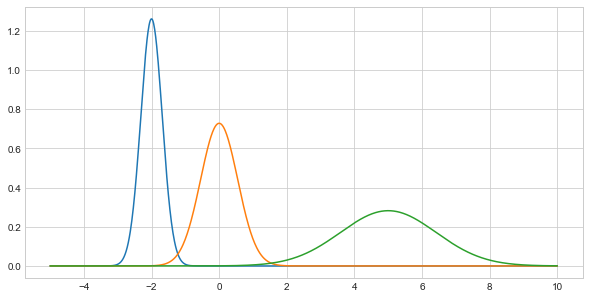

In [2]:
def gaussian(x, mu,sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

mu1, sigma1 = -2, np.sqrt(0.1)
mu2, sigma2 = 0, np.sqrt(0.3)
mu3, sigma3 = 5, np.sqrt(2)

## plotting code
fig, ax = plt.subplots(figsize=(10,5))
x = np.linspace(-5,10,1000)

ax.plot(x, ([gaussian(x_, mu1, sigma1) for x_ in x]))
ax.plot(x, ([gaussian(x_, mu2, sigma2) for x_ in x]))
ax.plot(x, ([gaussian(x_, mu3, sigma3) for x_ in x]))

plt.show()

Imagine we are modelling the height (in centimetres) of a population. We could specify that the mean height of the population was 160cm, with a variance of 10cm ($H_{cm} \sim \mathcal{N}(160, 10^2)$).

We can plot a _probability density_ for this using the Gaussian equation. The _density_ at a given height (in cm) tells us how often we can expect to see people at that height. 

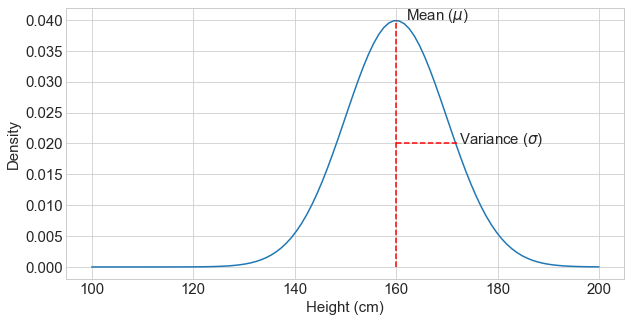

In [8]:
mu, sigma = 160, 10
population_size = 100

# on the x axis, we want all of the heights between 100cm and 200cm
heights = np.linspace(100,200,population_size) # 100 samples
density = [gaussian(x, mu, sigma) for x in heights]



#### plotting code: you can ignore this since it's just annotating
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(heights, density)

ax.plot([160]*10,np.linspace(0,.04,10), linestyle='--', color='red')
ax.plot(np.linspace(160,172,10), [0.02]*10, linestyle='--', color='red')

ax.annotate("Mean ($\mu$)",(162, .04))
ax.annotate("Variance ($\sigma$)", (172.5,0.02))

ax.set_xlabel('Height (cm)')
ax.set_ylabel('Density')
plt.show()

#### Sampling from a Gaussian

One of the benefits of defining our population this way is that we can take samples. We could take 100 samples from our Gaussian (each sample representing the height of one person), and we would expect this list of 100 heights to be roughly representative of our real population.
 
`numpy` provides a particularly simple way to sample from Gaussians. E.g. to take `n` samples:

```
n_samples = np.random.normal(mu, sigma, n) 
```
 
To picture what this looks like, imagine that each of the crosses on the below plot are individual samples from our model:

[172.3968381  154.28906806 164.96786599 152.7156074  166.96799141
 143.07075314 169.97963615 139.50447746 156.84770476 148.75489378
 175.35564076 165.21383586 162.94776029 153.78605734 169.12015889
 146.82843661 164.57128947 179.93755496 177.1138189  158.81814388]


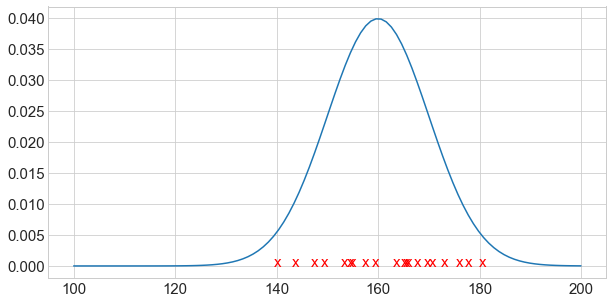

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(heights, density)

## let's sample
n = 20
samples = np.random.normal(mu, sigma, n)

print(samples)

for s in samples:
    ax.annotate('x',(s,0), color='red')

plt.show()

Imagine now that we would also like to incorporate _weight_ (in kg) into our model. 

We could define a new Gaussian distribution, with a different mean and variance. If we wanted to sample a new person (represented by a pair of a height and a weight $(h,w)$, we could first draw a sample from our model of height, and then another from our model of weight.


Example of a sampled person: 
    height (cm):  [162.42731365]
    weight (kg):  [53.52729087]


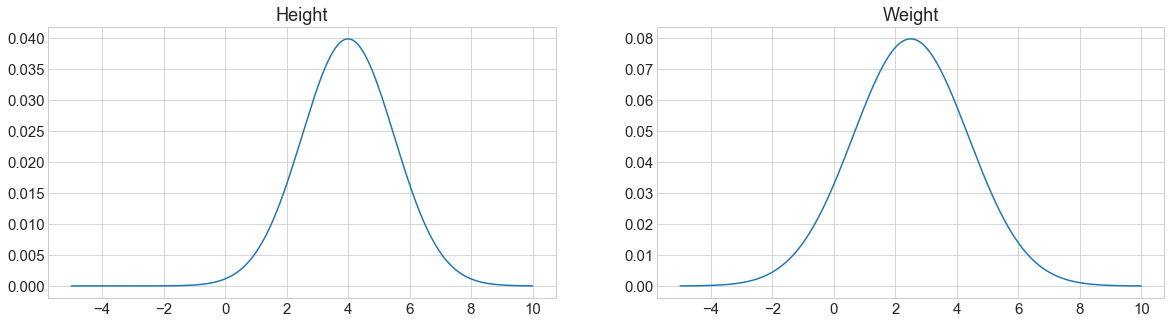

In [24]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs = axs.ravel()

mu_h, sigma_h = 160, 10
mu_w, sigma_w = 50, 5

x_h = np.linspace(100,200,1000)
x_w = np.linspace(30,70,1000)

axs[0].plot(x, ([gaussian(x_, mu_h, sigma_h) for x_ in x_h]))
axs[1].plot(x, ([gaussian(x_, mu_w, sigma_w) for x_ in x_w]))


axs[0].set_title('Height')
axs[1].set_title('Weight')


###### TAKING A SAMPLE 
h = np.random.normal(mu_h, sigma_h, 1)
w = np.random.normal(mu_w, sigma_w, 1)

print('Example of a sampled person: ')
print('    height (cm): ', h)
print('    weight (kg): ', w)

plt.show()

## Multivariate Gaussians

The problem with this is that we are assuming that height and weight are independent, when in reality they are heavily linked. We could very easily sample a height from above the mean and a weight from below the mean, and we would have nothing to alert us that this was unlikely.

So far, we have been considering _univariate_ Gaussians, and treating each variable as independent. When we have multiple, related variables (e.g. height and weight), a more powerful choice is the _multivariate_ Gaussian. 

When we specify a *multivariate* Gaussian, we swap our scalar mean for a vector $\mathbf{\mu}$, defining one mean per variable.

For example, in our height/weight example:

$$ \mathbf{\mu} = \begin{bmatrix} \mu_{h} \\ \mu_{w} \\ \end{bmatrix} = \begin{bmatrix} 160 \\ 50 \\ \end{bmatrix} $$

To replace the variance ($\sigma$), we need to specify a _covariance matrix_ ($\Sigma$). A covariance matrix needs to specify the variance of each variable, as well as how each pair of variables _covaries_. A positive covariance says that if one variable goes up in value, so does the other. A negative covariance says that if one goes up, the other goes down. A covariance of zero specifices that there is no relationship between the two.

The easiest way to get some intuition for this is visually:

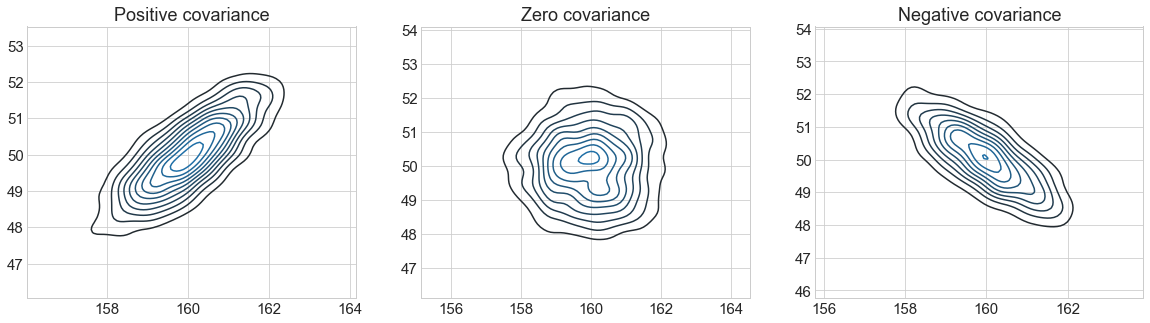

In [45]:
fig, ax = plt.subplots(1,3,figsize=(20,5))


### Positive covariance
mean = [160, 50]
cov  = [[1,.8],[.8,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

sns.kdeplot(x,y,ax=ax[0])
ax[0].set_title('Positive covariance')


### Zero covariance
mean = [160, 50]
cov  = [[1,0],[0,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

sns.kdeplot(x,y,ax=ax[1])
ax[1].set_title('Zero covariance')


### Negative covariance
mean = [160, 50]
cov  = [[1,-.8],[-.8,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

sns.kdeplot(x,y,ax=ax[2])
ax[2].set_title('Negative covariance')

plt.show()

This fits nicely on a 2D plot, so we can visualise individual samples from our model very easily (the red x):

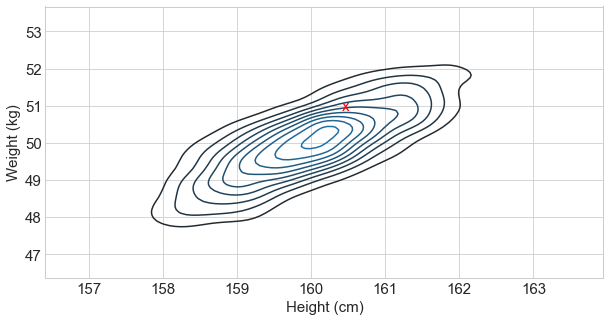

In [46]:
fig, ax = plt.subplots(figsize=(10,5))

### Positive covariance
mean = [160, 50]
cov  = [[1,.8],[.8,1]]  
x, y = np.random.multivariate_normal(mean, cov, 1000).T

s_x, s_y = np.random.multivariate_normal(mean, cov, 1).T

sns.kdeplot(x,y,ax=ax)

ax.annotate('x',(s_x,s_y),color='red')
ax.set_xlabel('Height (cm)')
ax.set_ylabel('Weight (kg)')

plt.show()

Unfortunately, this kind of visualisation becomes completely impossible once we have more than three variables (dimensions) to consider. 

A more scalable way to picture taking samples from the distribution is to put each of the variables as individual locations on the x-axis, and to normalise the y-axis to the range 0-1:

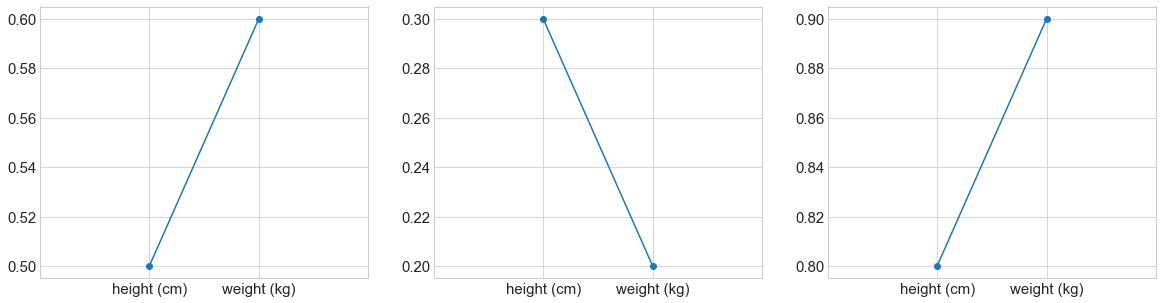

In [61]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs = axs.ravel()


x = [0,1]
ys = [[0.5,0.6],[0.3,0.2],[0.8,0.9]]

for ax,y in zip(axs,ys):
    ax.plot(x,y, marker='o')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['height (cm)', 'weight (kg)'])
    ax.set_xlim(-1,2)

plt.show()


Imagine that the above 